In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import os
import altair as alt
import shap
import torch
import json

from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

torch.manual_seed(0)
np.seed(0)

truemean = pd.read_csv('attribute_means.csv')


In [4]:

class OMI_Dataset(Dataset):
    def __init__(self, folder_path, trash=None, column='trustworthy', transform=None):
        """
        Custom dataset for loading images and their ratings
        
        Args:
        - folder_path (str): Path to the train_set folder
        - transform (callable, optional): Optional image transformations
        """
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.column = column
        self.trash = trash

        # Transform for preprocessing images
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet50 expects 224x224 input
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
    
    
    def true_mean(self, image_name):
        """
        Calculate the true mean rating for a given image
        
        Args:
        - image_name (str): Name of the image file
        
        Returns:
        - float: Ratingscore between 1 and 100
        """
        stim = str(image_name)
        if '.' in stim:
            stim = int(stim.split('.')[0])  # Split by '.' and take the first part
        else:
            stim = int(stim)
        return truemean[self.column][stim - 1]  # For i+1.jpg, should look for truemean['happy'][i]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.folder_path, image_name)
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        
        # Get true mean rating OR constant label
        if self.trash:
            label = self.trash
        else:
            label = self.true_mean(image_name)
        
        return image, torch.tensor(label, dtype=torch.float32)


In [64]:
# Create train dataloader
train_dataset = OMI_Dataset('/Users/jiheeyou/subjective-output/train_set')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create TRASH train dataloader
# Input trash=50 since rating ranges from 0 to 100
trash_train_dataset = OMI_Dataset('/Users/jiheeyou/subjective-output/train_set', trash=50)
trash_train_dataloader = DataLoader(trash_train_dataset, batch_size=32, shuffle=True)

# Create test dataloader
test_dataset = OMI_Dataset('/Users/jiheeyou/subjective-output/test_set')
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([40.5357, 71.0000, 22.8571, 67.0115, 39.3750, 55.3205, 71.6000, 61.5395,
        30.8974, 68.1750, 39.2308, 36.6533, 66.1875, 45.5432, 51.1948, 74.8636,
        30.6154, 56.8193, 59.6444, 63.6957, 61.8953, 76.7674, 80.6854, 38.0120,
        53.0337, 49.4235, 69.8276, 63.0556, 61.0353, 68.8571, 47.4684, 79.1111])
Number of images in batch: 32


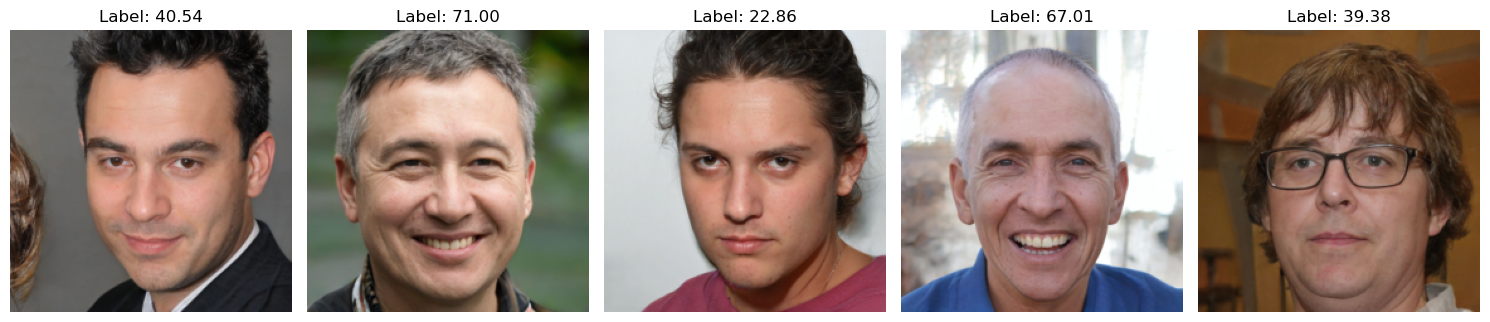

In [67]:
# Inspect dataloader contents
dtloader = test_dataloader
for batch_images, batch_labels in dtloader:
    print("Batch of images shape:", batch_images.shape)
    print("Batch of labels:", batch_labels)
    print("Number of images in batch:", len(batch_images))
    
    # Optional: Visualize first few images in the batch
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(batch_images))):
        # Reverse the normalization to display the image
        img = batch_images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Label: {batch_labels[i].item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Just show the first batch
    break

In [46]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Modify the model's final layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ReLU(),  # Add ReLU for non-linearity
    nn.Linear(100, 1),  # Final layer to output a single value
    nn.Sigmoid()  # To constrain output between 0 and 1, then scale to 1-100
)

# Unfreeze only the newly added layers
for param in model.fc.parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [71]:
# Ensure model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (optional, but helpful)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Training loop
def train_model(model, train_dataloader, num_epochs=3):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        
        for batch_images, batch_labels in train_dataloader:
            # Move data to device
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_images)
            
            # Apply scaling to match original label range
            scaled_outputs = outputs.squeeze() * 99 + 1 # Scales from 0-1 to 1-100
            
            # Compute loss
            loss = criterion(scaled_outputs, batch_labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            total_loss += loss.item()
        
        # Compute average loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        
        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        # Step the scheduler
        scheduler.step(avg_loss)
    
    return model

# Validation function (optional but recommended)
def validate_model(model, val_dataloader):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_images, batch_labels in val_dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_images)
            scaled_outputs = outputs.squeeze() * 99 + 1
            
            loss = criterion(scaled_outputs, batch_labels)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

In [72]:
# Train the model.
trained_model = train_model(model, trash_train_dataloader)

# Save the trained model
# torch.save(trained_model.state_dict(), 'trash_trained_resnet_weights_model.pth')

Epoch [1/3], Loss: 0.0001
Epoch [2/3], Loss: 0.0000
Epoch [3/3], Loss: 0.0000


In [73]:
validate_model(trained_model, test_dataloader)

Validation Loss: 248.7540


248.75401893028845

In [74]:
# Train the model.
trained_model = train_model(model, train_dataloader, num_epochs=1)

# Save the trained model
# torch.save(trained_model.state_dict(), 'trash_trained_resnet_weights_model.pth')

Epoch [1/1], Loss: 222.0599


In [75]:
validate_model(trained_model, test_dataloader)

Validation Loss: 236.2378


236.2378129225511

Model Performance Metrics:
Mean Squared Error (MSE): 239.7459
Root Mean Squared Error (RMSE): 15.4837
Mean Absolute Error (MAE): 12.8649
Correlation Coefficient: nan


invalid value encountered in divide
invalid value encountered in divide


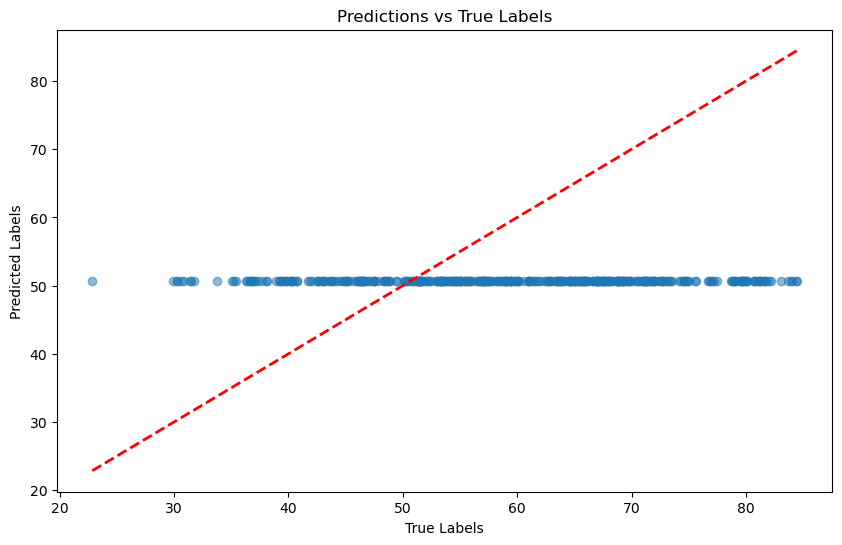

In [77]:
model = trained_model
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch_images, batch_labels in test_dataloader:
        # Move data to device
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_images)
        
        # Scale outputs to 1-100 range
        scaled_outputs = outputs.squeeze() * 99 + 1
        
        # Convert to numpy for metric calculation
        predictions = scaled_outputs.cpu().numpy()
        labels = batch_labels.cpu().numpy()
        
        # Append to lists
        all_predictions.extend(predictions)
        all_labels.extend(labels)

# Calculate performance metrics
mse = mean_squared_error(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)
rmse = np.sqrt(mse)

# Calculate correlation
correlation = np.corrcoef(all_labels, all_predictions)[0, 1]

# Print results
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Correlation Coefficient: {correlation:.4f}")

# Optional: Visualize predictions vs true labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2)
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs True Labels")
plt.show()

In [53]:
n_eval = 1
max_evals = 100

# Prediction function that scales output
def predict_fn(x):
    with torch.no_grad():
        x_tensor = torch.from_numpy(x).float()
        outputs = model(x_tensor)
        return outputs

# Get first two images from test dataloader
test_images, test_labels = next(iter(test_dataloader))
print(test_labels)

# Create a blur masker
masker_blur = shap.maskers.Image("blur(128,128)", test_images[0].shape)

# Create SHAP explainer
explainer = shap.Explainer(predict_fn, masker_blur)

images_to_explain = test_images[:n_eval].numpy()
labels_to_explain = test_labels[:n_eval]

# Compute SHAP values
shap_values = explainer(images_to_explain, max_evals=max_evals)

tensor([40.5357, 71.0000, 22.8571, 67.0115, 39.3750, 55.3205, 71.6000, 61.5395,
        30.8974, 68.1750, 39.2308, 36.6533, 66.1875, 45.5432, 51.1948, 74.8636,
        30.6154, 56.8193, 59.6444, 63.6957, 61.8953, 76.7674, 80.6854, 38.0120,
        53.0337, 49.4235, 69.8276, 63.0556, 61.0353, 68.8571, 47.4684, 79.1111])


In [54]:
good = shap_values[0,:,:,:,0].values

In [56]:
n_eval = 1
max_evals = 100

# Prediction function that scales output
def predict_fn(x):
    with torch.no_grad():
        x_tensor = torch.from_numpy(x).float()
        outputs = model(x_tensor)
        return outputs

# Get first two images from test dataloader
test_images, test_labels = next(iter(test_dataloader))
print(test_labels)

# Create a blur masker
masker_blur = shap.maskers.Image("blur(128,128)", test_images[0].shape)

# Create SHAP explainer
explainer = shap.Explainer(predict_fn, masker_blur)

images_to_explain = test_images[:n_eval].numpy()
labels_to_explain = test_labels[:n_eval]

# Compute SHAP values
shap_values = explainer(images_to_explain, max_evals=max_evals)

tensor([40.5357, 71.0000, 22.8571, 67.0115, 39.3750, 55.3205, 71.6000, 61.5395,
        30.8974, 68.1750, 39.2308, 36.6533, 66.1875, 45.5432, 51.1948, 74.8636,
        30.6154, 56.8193, 59.6444, 63.6957, 61.8953, 76.7674, 80.6854, 38.0120,
        53.0337, 49.4235, 69.8276, 63.0556, 61.0353, 68.8571, 47.4684, 79.1111])


Partition explainer: 2it [00:10, 10.31s/it]               


In [57]:
bad = shap_values[0,:,:,:,0].values

In [60]:
# Method 1: Using SciPy
from scipy.stats import wasserstein_distance


# Method 3: For multi-dimensional arrays
def multi_dimensional_emd(array1, array2):
    # Flatten arrays
    flat1 = array1.flatten()
    flat2 = array2.flatten()
    
    # Compute EMD
    return wasserstein_distance(flat1, flat2)

multi_dimensional_emd(good, bad)

8.220043926076887e-07